# Modeling options and result analysis in scCODA

This tutorial notebook serves as an extension to the general tutorial and presents ways to alternate the model and perform more in-depth result analysis and diagnostics.
We will focus on:

- Modifications of the model formula and reference cell type to perform different modeling tasks
- Inference methods available in scCODA
- Advanced interpretation and analysis of results
- Alternative differential abundance testing using all references

We will again analyze the small intestinal epithelium data of mice from [Haber et al., 2017](https://www.nature.com/articles/nature24489).
First, we read in the data and perform the same preprocessing steps as in the general tutorial:

In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

Entire dataset: AnnData object with n_obs × n_vars = 10 × 8
    obs: 'Mouse', 'Condition'
Salmonella dataset: AnnData object with n_obs × n_vars = 6 × 8
    obs: 'Mouse', 'Condition'


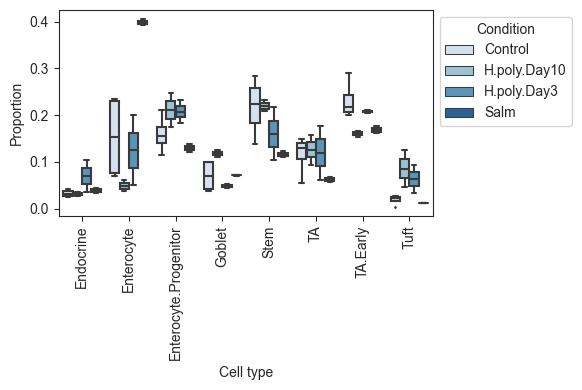

In [2]:
# Load data
cell_counts = scd.haber()

# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_all.obs["Condition"] = data_all.obs["Mouse"].str.replace(r"_[0-9]", "", regex=True)
print(f"Entire dataset: {data_all}")

# Select control and salmonella data
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])].copy()
print(f"Salmonella dataset: {data_salm}")

viz.boxplots(data_all, feature_name="Condition")
plt.show()


## Tweaking the model formula and reference cell type

First, we take a closer look at how changing the `formula` parameter of the scCODA model influences the results.
Internally, the formula string is converted into a linear model-like design matrix via [patsy](https://patsy.readthedocs.io/en/latest/),
which has a similar syntax to the `lm` function in the R language.

### Multi-level categories

Patsy allows us to automatically handle categorical covariates, even with multiple levels.
For example, we can model the effect of all three diseases at once:

In [3]:
# model all three diseases at once
model_all = mod.CompositionalAnalysis(data_all, formula="Condition", reference_cell_type="Endocrine")
all_results = model_all.sample_hmc()
all_results.summary()

2021-11-28 19:15:21.670317: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2021-11-28 19:15:23.943628: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
  0%|          | 0/20000 [00:00<?, ?it/s]2021-11-28 19:15:25.649198: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd21d1c63a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-28 19:15:25.649348: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2021-11-28 19:15:28.022894: I tensorflow/compiler/jit/xla_compilation_cache.cc:337] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 20000/20000 [01:38<00:00, 203.36it/s]


MCMC sampling finished. (123.099 sec)
Acceptance rate: 78.2%
Compositional Analysis summary:

Data: 10 samples, 8 cell types
Reference index: 0
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        0.986        46.634633
Enterocyte                       1.905       116.902874
Enterocyte.Progenitor            2.348       182.061302
Goblet                           1.474        75.970374
Stem                             2.427       197.027528
TA                               1.878       113.788726
TA.Early                         2.534       219.278684
Tuft                             0.626        32.535879


Effects:
                                                 Final Parameter  \
Covariate                 Cell Type                                
Condition[T.H.poly.Day10] Endocrine                     0.000000   
                          Enterocyte             

### Different reference levels

Per default, categorical variables are encoded via full-rank treatment coding. Hereby, the value of the first sample in the dataset is used as the default (control) category.
We can select the default level by changing the model formula to `"C(<CovariateName>, Treatment('<ReferenceLevelName>'))"`:

For example, we can switch the salmonella model to test diseased versus healthy samples, which switches the sign of the only credible effect (Enterocytes).

In [4]:
# Set salmonella infection as "default" category

model_salm_switch_cond = mod.CompositionalAnalysis(data_salm, formula="C(Condition, Treatment('Salm'))", reference_cell_type="Goblet")
switch_results = model_salm_switch_cond.sample_hmc()
switch_results.summary()

100%|██████████| 20000/20000 [01:02<00:00, 317.86it/s]


MCMC sampling finished. (82.254 sec)
Acceptance rate: 49.8%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: C(Condition, Treatment('Salm'))

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.269        28.559849
Enterocyte                       3.708       327.340808
Enterocyte.Progenitor            2.566       104.480647
Goblet                           1.777        47.465439
Stem                             2.615       109.727702
TA                               2.048        62.240247
TA.Early                         2.877       142.594061
Tuft                             0.450        12.591247


Effects:
                                                                  Final Parameter  \
Covariate                                  Cell Type                                
C(Condition, Treatment('Salm'))[T.Control] Endocrine           

### Switching the reference cell type

Compositional analysis generally does not allow statements on absolute abundance changes, but only in relation to a reference category,
which is assumed to be unchanged in absolute abundance.
The reference cell type fixes this category in scCODA. Thus, an interpretation of scCODA's effects should always be formulated like:

"Using cell type xy as a reference, cell types (a, b, c) were found to credibly change in abundance"

Switching the reference cell type might thus produce different results.
For example, if we choose a different cell type as the reference (such as Enterocytes in the salmonella infection data),
scCODA can find other credible effects on the other cell types.

In [13]:
model_salm_ref = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type="Enterocyte")
reference_results = model_salm_ref.sample_hmc()
reference_results.summary()

100%|██████████| 20000/20000 [01:02<00:00, 321.43it/s]


MCMC sampling finished. (80.035 sec)
Acceptance rate: 54.2%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 1
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        0.563        34.927176
Enterocyte                       2.088       160.495387
Enterocyte.Progenitor            1.870       129.058424
Goblet                           1.100        59.755737
Stem                             2.095       161.622796
TA                               1.475        86.944084
TA.Early                         2.220       183.142621
Tuft                            -0.043        19.053774


Effects:
                                         Final Parameter  Expected Sample  \
Covariate         Cell Type                                                 
Condition[T.Salm] Endocrine                          0.0        34.927176   
                  Entero

## Inference algorithms in scCODA

Currently, scCODA performs parameter inference via Markov-chain Monte Carlo (MCMC) methods.
There are three different MCMC sampling methods available for scCODA:

- Hamiltonian Monte Carlo (HMC) sampling: `sample_hmc()`
- HMC sampling with Dual-averaging step size adaptation ([Nesterov, 2009](https://link.springer.com/article/10.1007/s10107-007-0149-x)): `sample_hmc_da()`
- No-U-Turn sampling ([Hoffman and Gelman, 2014](https://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf)): `sample_nuts()`

Generally, it is recommended to use the standard HMC sampling. Other methods, such as variational inference, are in consideration.

For all MCMC sampling methods, properties such as the MCMC chain length and the number of burn-in samples are directly adjustable.

## Result analysis and diagnostics

The "getting started" tutorial explains how to do interpret the basic output of scCODA.
To follow this up, we now take a look at how MCMC diagnostics and more advanced result analysis in scCODA can be performed.

For this section, we again use the model of salmonella infection versus control group, with a reference cell type of Goblet cells.

In [6]:
model_salm = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type="Goblet")
salm_results = model_salm.sample_hmc(num_results=20000)

100%|██████████| 20000/20000 [01:03<00:00, 314.08it/s]


MCMC sampling finished. (80.894 sec)
Acceptance rate: 55.8%


### Extended model summary

`result.summary_extended()` gives us, apart from the properties already explained in the basic tutorial, more information about the posterior inferred by the model.
The extended summary also includes some information on the MCMC sampling procedure (chain length, burn-in, acceptance rate, duration).

For both effects and intercepts, we also get the standard deviation (SD) and high density interval endpoints of the posterior density of the generated Markov chain.

The effects summary also includes the spike-and-slab inclusion probability for each effect, i.e. the share of MCMC samples, for which this effect was not set to 0 by the spike-and-slab prior.
A threshold on this value serves as the deciding factor whether an effect is considered statistically credible

We can also use the summary tables from `summary_extended()` as pandas DataFrames to tweak them further.
They are also accessible as `result.intercept_df` and `result.effect_df`, respectively.
Furthermore, the tables a direct result of the `summary()` function in [arviz](https://arviz-devs.github.io/arviz/index.html) and support all its functionality.
This means that we can, for example, change the credible interval:

In [7]:
salm_results.summary_extended(hdi_prob=0.9)


Compositional Analysis summary (extended):

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition
Spike-and-slab threshold: 1.000

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 80.894 sec. Acceptance rate: 55.8%

Intercepts:
                       Final Parameter  HDI 5%  HDI 95%     SD  \
Cell Type                                                        
Endocrine                        1.105   0.548    1.750  0.369   
Enterocyte                       2.330   1.842    2.844  0.312   
Enterocyte.Progenitor            2.517   2.055    3.071  0.310   
Goblet                           1.749   1.253    2.277  0.316   
Stem                             2.710   2.229    3.235  0.306   
TA                               2.114   1.576    2.658  0.330   
TA.Early                         2.858   2.361    3.341  0.297   
Tuft                             0.433  -0.210    1.065  0.394   

                       Expected Sample  
Cell Type                             


### Diagnostics and plotting

Similarly to the summary dataframes being compatible with [arviz](https://arviz-devs.github.io/arviz/index.html),
the result class itself is an extension of arviz's `Inference Data` class. This means that we can use all its MCMC diagnostic and plotting functionality.
As an example, looking at the MCMC trace plots and kernel density estimates, we see that they are indicative of a well sampled MCMC chain:

Note: Due to the spike-and-slab priors, the `beta` parameters have many values at 0, which looks like a convergence issue, but is actually not.

**Caution: Trying to plot a kernel density estimate for an effect on the reference cell type results in an error, since it is constant at 0 for the entire chain.
To avoid this, add** `coords={"cell_type": salm_results.posterior.coords["cell_type_nb"]}` **as an argument to `az.plot_trace`, which causes the plots for the reference cell type to be skipped.**

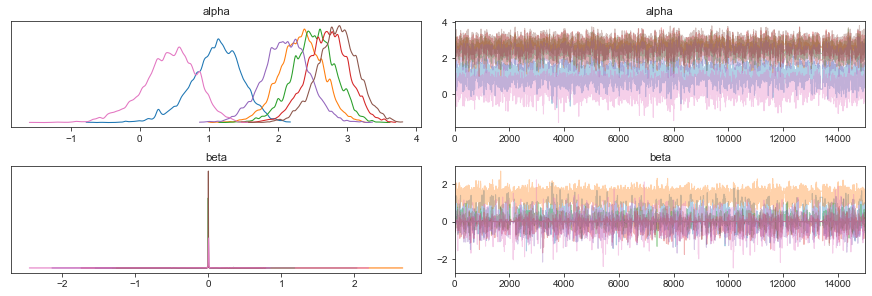

In [8]:
az.plot_trace(
    salm_results,
    divergences=False,
    var_names=["alpha", "beta"],
    coords={"cell_type": salm_results.posterior.coords["cell_type_nb"]},
)
plt.show()

### Using all cell types as reference alternatively to reference selection

scCODA uses a reference cell type that is considered to be unchanged over the experiment to guarantee the unique identifiability of results.
If no such cell type is known beforehand, setting `reference_cell_type="automatic"` will find a suited reference.
Alternatively, it is possible to find credible effects on cell types that are mostly independent of the reference.
By sequentially running scCODA and selecting each cell type as the reference once, we can then use a majority vote to find the cell types that were credibly changing more than half of the time.

Below, an example code for this procedure on the Salmonella infection data shows that only Enterocytes were found to be credible more than half of the time.
Indeed, they re credibly changing for every reference cell type except themselves.
All other cell types were not found to change with any reference.

In [9]:
# Run scCODA with each cell type as the reference
cell_types = data_salm.var.index
results_cycle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    model_temp = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type=ct)
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Select credible effects
    cred_eff = temp_results.credible_effects()
    cred_eff.index = cred_eff.index.droplevel(level=0)

    # add up credible effects
    results_cycle["times_credible"] += cred_eff.astype("int")

Reference: Endocrine


100%|██████████| 20000/20000 [01:03<00:00, 313.42it/s]


MCMC sampling finished. (81.026 sec)
Acceptance rate: 50.1%
Reference: Enterocyte


100%|██████████| 20000/20000 [01:04<00:00, 309.59it/s]


MCMC sampling finished. (85.399 sec)
Acceptance rate: 56.5%
Reference: Enterocyte.Progenitor


100%|██████████| 20000/20000 [01:08<00:00, 291.32it/s]


MCMC sampling finished. (93.835 sec)
Acceptance rate: 60.7%
Reference: Goblet


100%|██████████| 20000/20000 [01:13<00:00, 271.64it/s]


MCMC sampling finished. (90.710 sec)
Acceptance rate: 58.2%
Reference: Stem


100%|██████████| 20000/20000 [01:07<00:00, 295.02it/s]


MCMC sampling finished. (86.994 sec)
Acceptance rate: 51.8%
Reference: TA


100%|██████████| 20000/20000 [01:22<00:00, 242.56it/s]


MCMC sampling finished. (103.528 sec)
Acceptance rate: 53.4%
Reference: TA.Early


100%|██████████| 20000/20000 [01:21<00:00, 244.23it/s]


MCMC sampling finished. (105.065 sec)
Acceptance rate: 54.0%
Reference: Tuft


100%|██████████| 20000/20000 [01:23<00:00, 240.64it/s]


MCMC sampling finished. (104.704 sec)
Acceptance rate: 49.7%


In [10]:
# Calculate percentages
results_cycle["pct_credible"] = results_cycle["times_credible"]/len(cell_types)
results_cycle["is_credible"] = results_cycle["pct_credible"] > 0.5
print(results_cycle)


                       times_credible  pct_credible  is_credible
Endocrine                           0         0.000        False
Enterocyte                          7         0.875         True
Enterocyte.Progenitor               0         0.000        False
Goblet                              0         0.000        False
Stem                                0         0.000        False
TA                                  0         0.000        False
TA.Early                            0         0.000        False
Tuft                                0         0.000        False
